In [1]:
from deep_traffic_generation.tcvae import TCVAE
from deep_traffic_generation.SecondStageVAE import VAE
from deep_traffic_generation.TwoStageGeneration import TwoStageVAE
from traffic.algorithms.generation import Generation
from deep_traffic_generation.core.datasets import TrafficDataset

from sklearn.preprocessing import MinMaxScaler
import torch
import numpy as np
from os import walk

# DataSet

In [2]:
dataset = TrafficDataset.from_file(
    "../../deep_traffic_generation/data/traffic_noga_tilFAF_train.pkl",
    features=["track", "groundspeed", "altitude", "timedelta"],
    scaler=MinMaxScaler(feature_range=(-1,1)),
    shape="image",
    info_params={"features": ["latitude", "longitude"], "index": -1},
)
dataset

Dataset TrafficDataset
    Number of datapoints: 14000
    MinMaxScaler(feature_range=(-1, 1))

# Plot Generation

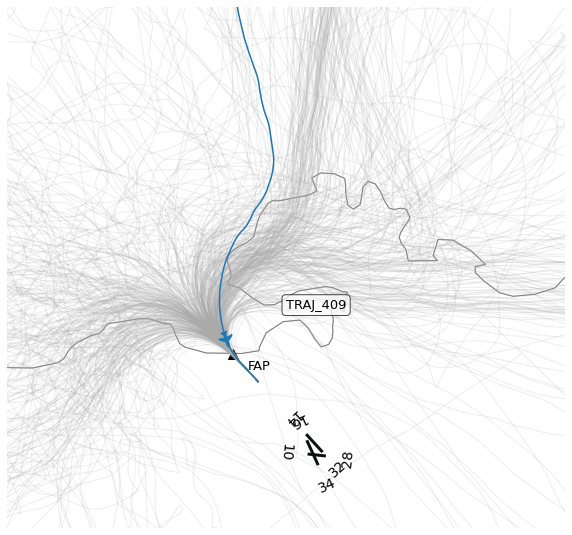

In [7]:
import matplotlib.pyplot as plt
from traffic.core.projection import EuroPP
from traffic.drawing import countries
from traffic.data import navaids
from traffic.data import airports

path_stage1 = "../../deep_traffic_generation/lightning_logs/tcvae/version_14/"
path_stage2 = "lightning_logs/version_2/"

t = TwoStageVAE(X = dataset, sim_type = "generation")
t.load(path_stage1, path_stage2, dataset.parameters)
t.get_second_stage_scaler()
g = Generation(generation=t, features = t.first_stage.hparams.features, scaler=dataset.scaler) #scaler of the first stage (the global scaler)


with plt.style.context("traffic"):
    fig, ax = plt.subplots(1, 1, figsize=(10, 15), subplot_kw=dict(projection=EuroPP()))
    ax.add_feature(countries())
    ax.figure

    ax.set_extent((8, 9, 47.37, 48))

    traf = g.sample(500, coordinates = dict(latitude = 47.546585, longitude = 8.447731), forward=False) #coordinates sont les coordonnées du dernier point car forward = False
    traf.plot(ax, alpha=0.2)

    k =  np.random.randint(len(traf))
    traf[k].plot(ax, color="#1f77b4", lw=1.5)
    traf[k].at_ratio(0.85).plot(
        ax,
        color="#1f77b4",
        zorder=3,
        shift=dict(units="dots", x=60, y=30),
        text_kw=dict(
            fontname="Fira Sans",
            bbox=dict(boxstyle="round", facecolor="white", alpha=0.7, zorder=5),
        ),
    )

    airports["LSZH"].plot(ax, footprint=False, runways=dict(lw=1), labels=False)
    airports["LSZH"].runways.plot(
        ax,
        runways=False,
        labels=True,
        shift=3000,
        text_kw=dict(fontname="Fira Sans", fontsize=14),
    )
    
    navaids["OSNEM"].plot(
        ax,
        zorder=2,
        marker="^",
        shift=dict(units="dots", x=15, y=-15),
        text_kw={
            "s": "FAP",
        },
    )

# Latent Spaces

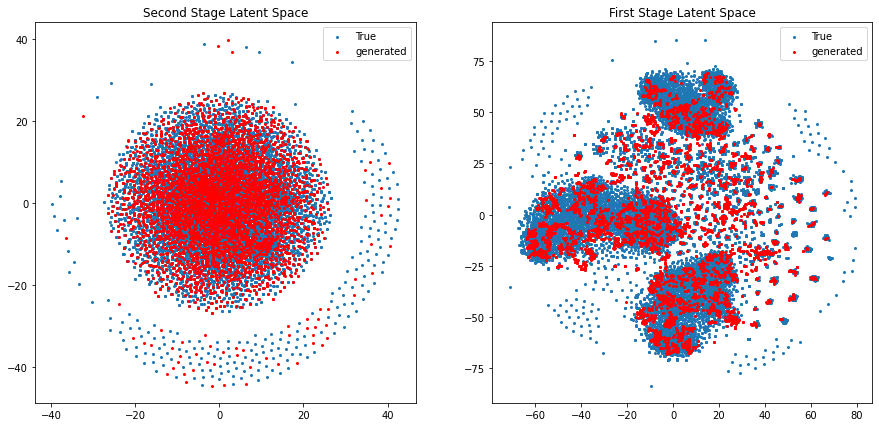

In [8]:
from sklearn.manifold import TSNE

#latent spaces of the second and first stages respectivly, and 100 generated points within (the last 100 rows of the array)
n_gen = 5000
U, Z = t.latent_spaces(n_gen)

Z_embedded = TSNE(n_components=2).fit_transform(Z)
U_embedded = TSNE(n_components=2).fit_transform(U)

fig, ax = plt.subplots(1,2, figsize=(15, 7))
ax[0].scatter(U_embedded[:-n_gen, 0], U_embedded[:-n_gen, 1], s=4, label = "True")
ax[0].scatter(U_embedded[-n_gen:, 0], U_embedded[-n_gen:, 1], s=4, c='red', label = "generated")
ax[0].title.set_text("Second Stage Latent Space")
ax[0].legend()

ax[1].scatter(Z_embedded[:-n_gen, 0], Z_embedded[:-n_gen, 1], s=4, label = "True")
ax[1].scatter(Z_embedded[-n_gen:, 0], Z_embedded[-n_gen:, 1], s=4, c='red', label = "generated")
ax[1].title.set_text("First Stage Latent Space")
ax[1].legend()
plt.show()

In [9]:
# Are the latent means of the first stage really next to the ring of standard gaussian in dimension 256 ?

quant = 3.69 #comme c'est 2 sided ca va nous donner une proba a 0.9998 alors que c'est le quantile 0.9999
up = np.sqrt(t.first_stage.lsr.out_dim) + quant/np.sqrt(2)
down = np.sqrt(t.first_stage.lsr.out_dim) - quant/np.sqrt(2)
print("range of norms : ", down, up)

#parameters of latent space distributions
h = t.first_stage.encoder(dataset.data)
# h = t.VAE.encoder(test.data)
q = t.first_stage.lsr(h)
params = t.first_stage.lsr.dist_params(q)
means_norms = np.linalg.norm(params[1].detach().numpy()[:,0,:], ord = 2, axis = 1)
mask = (means_norms < up) & (means_norms > down)
print("proportion of means well located for a standard gaussian :", mask.sum()/len(mask))
print("quantiles 0.25, 0.5 and 0.75 of means : ", np.quantile(means_norms, [0.25, 0.5, 0.75]))

range of norms :  13.39077597742164 18.60922402257836
proportion of means well located for a standard gaussian : 0.07442857142857143
quantiles 0.25, 0.5 and 0.75 of means :  [ 8.34447336  9.90971231 19.06789017]


In [10]:
# Are the latent means of the second stage really next to the ring of standard gaussian in dimension 256 ?

quant = 3.69 #comme c'est 2 sided ca va nous donner une proba a 0.9998 alors que c'est le quantile 0.9999
up = np.sqrt(t.first_stage.lsr.out_dim) + quant/np.sqrt(2)
down = np.sqrt(t.first_stage.lsr.out_dim) - quant/np.sqrt(2)
print("range of norms : ", down, up)

#parameters of latent space distributions
h_1 = t.first_stage.encoder(dataset.data)
q_1 = t.first_stage.lsr(h_1)
z_1 = q_1.rsample()
h_2 = t.second_stage.encoder(z_1)
params = t.second_stage.fc_mu(h_2)
means_norms = np.linalg.norm(params.detach().numpy(), ord = 2, axis = 1)
mask = (means_norms < up) & (means_norms > down)
print("proportion of means well located for a standard gaussian :", mask.sum()/len(mask))
print("quantiles 0.25, 0.5 and 0.75 of means : ", np.quantile(means_norms, [0.25, 0.5, 0.75]))



range of norms :  13.39077597742164 18.60922402257836
proportion of means well located for a standard gaussian : 0.12321428571428572
quantiles 0.25, 0.5 and 0.75 of means :  [ 5.34524369 10.39614439 18.03180265]


In [22]:
#Normality test for the dimensions of the second stage

from scipy.stats import kstest

#testing the normality of the distribution of the means along each dimension
#p_value = proba to abserve a most extreme value than the one observed with the stat under the null hypothesis
#low p_value -> reject null
p_values = []

for i in range(t.first_stage.lsr.out_dim):
    stat, p_value = kstest(params[i].detach().numpy(), "norm")
    p_values.append(p_value)

print("Number of dimensions not necessarly non-Gaussian :", np.sum(np.array(p_values) > 0.001))

Number of dimensions considered as Gaussian : 3


# Generated trajectories build with a combination of latent space elements

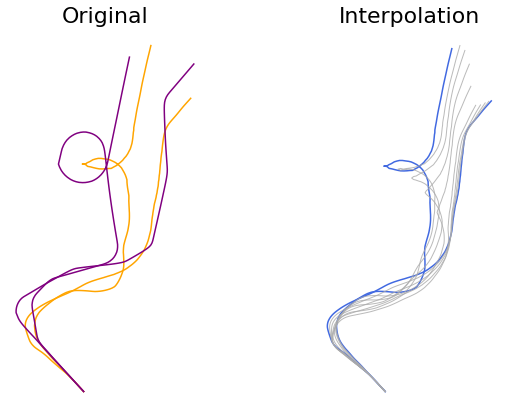

In [7]:
# i = np.random.randint(len(dataset))
# j = np.random.randint(len(dataset))

i,j = 3297, 4334

u1 = U[i]
u2 = U[j]
lambdas = list(np.linspace(0,1,10))
u_inter = []

for lam in lambdas:
    u_inter.append(lam*u1 + (1-lam)*u2)

u_inter = np.array(u_inter)

out = t.decode(torch.tensor(u_inter))
out_traf = g.build_traffic(out, coordinates = dict(latitude = 47.546585, longitude = 8.447731), forward=False)

original = dataset.data[[i,j]]
original = original.transpose(1,2).reshape((original.shape[0], -1))
original = dataset.scaler.inverse_transform(original)
original_traf = g.build_traffic(original, coordinates = dict(latitude = 47.546585, longitude = 8.447731), forward=False)


with plt.style.context("traffic"):
    fig, ax = plt.subplots(1, 2, subplot_kw=dict(projection=EuroPP()))
    ax[0].set_title("Original")
    out_traf[0].plot(ax[0], c="orange", label="Existing reconstructed")
    out_traf[9].plot(ax[0], c="orange", label="Existing reconstructed")
    original_traf.plot(ax[0], c="purple", label="Existing")
    ax[1].set_title("Interpolation")
    out_traf[0].plot(ax[1], c = "royalblue", label = "reconstructed")
    out_traf[9].plot(ax[1], c = "royalblue", label = "reconstructed")
    out_traf[1:9].plot(ax[1], label = "interpolated")


    plt.show()
